# Wykorzystanie głebokich konwolucyjnych do klasyfikacji cech twarzy ze zbioru CelebA

<img src="https://pbs.twimg.com/media/Cxf17XAUAAAnGX9.jpg",width=800>
<img src="http://mmlab.ie.cuhk.edu.hk/projects/celeba/intro.png",width=800>

http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

## Doinstalowanie brakujących bibliotek

In [1]:
!pip install --user -r ../requirements.txt

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Zaimportowanie bibliotek

In [1]:
#operacje związane ze ścieżkami
import os
from glob import glob

#operacje na macierzach
import numpy as np

#operacje na danych tabelarycznych
import pandas as pd

#operacje na obrazach
from PIL import Image

#miła dla oka wizualizacja postępu i nie tylko
from tqdm import tqdm

#tworzenie wykresów i wizualizacja danych
import matplotlib.pyplot as plt
import seaborn as sns

#funkcja ułatwiająca podział zbioru danych na treningowy i testowy
from sklearn.model_selection import train_test_split

#importy z biblioteki keras, umożlkiwiające krótszy zapis implementacji
from keras.layers import Dense, Input, Dropout
from keras.layers import Conv2D, Flatten, MaxPooling2D
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
np.random.seed(1118) #ziarno do generacji liczb pseudolosowych - wybierz swoje, ale może wpłynąć na wyniki

## Stałe wykorzystywane w następnych krokach

In [3]:
dataset_dir = '../img_align_celeba'
model_dir = '../models'

os.makedirs(dataset_dir,exist_ok=True)
os.makedirs(model_dir,exist_ok=True)

labels_path = '../list_attr_celeba.txt'

## Pobranie i rozpakowanie danych

* Linux (lub inny system unixowy, działa też na WSL)

In [4]:
!wget https://www.dropbox.com/s/lpmjzzk26nae9bh/img_align_celeba.zip -P ./..
!unzip -q -d ../img_align_celeba ../img_align_celeba.zip
!wget https://www.dropbox.com/s/qpjuy9isvm19xsv/list_attr_celeba.txt -P ./..

'wget' is not recognized as an internal or external command,
operable program or batch file.
'7z' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


* Windows

Pobierz plik zip ze strony dropbox i wypakuj wybranym programem do obsługi archiwów zip.

## Wczytanie danych

In [5]:
attributes = []
with open(labels_path, 'r') as f:
    f.readline()
    attribute_names = ['fn']+f.readline().strip().split(' ')
    for i, line in enumerate(f):
        fields = line.strip().replace('  ', ' ').split(' ')
        img_name = fields[0]
        if int(img_name[:6]) != i + 1:
            raise ValueError('Parse error.')
        attr_vec = np.array([fields[0]]+[int(x) for x in fields[1:]])
        attributes.append(attr_vec)
attributes = np.array(attributes)

In [6]:
df = pd.DataFrame(data=attributes,columns=attribute_names)
df.head()

,fn,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


### Dostępne cechy

In [7]:
for feature in df.columns[1:]:
    print(feature)

5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Smiling
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


### Badana cecha

In [8]:
examined_feature = 'Eyeglasses'

## Tutaj trzebaby tylko chyba wyciac kawalek z oczami wg wspolrzednych + obszar

### Wykorzystamy losowo wybrane (maksymalnie) 10 000 obrazów

#### Zbalansowanie porządanej cechy

In [9]:
df_balanced = df.groupby(examined_feature)
n_samples = np.min([10000//2,df_balanced.size().min()])
n_samples

5000

In [10]:
df_balanced = pd.DataFrame(df_balanced.apply(lambda x: x.sample(n_samples).reset_index(drop=True)))

In [11]:
print('Mamy',str(len(df_balanced)),'obrazów')

Mamy 10000 obrazów


#### Wczytanie danych

* etykiet

In [12]:
labels = (df_balanced[examined_feature].values) == '1'

* obrazów

Następnie poddamy je następującym zabiegom:
* Odcięcie krawędzi - umożliwiające relatywnie bezstratne wykonanie operacji 2-krotnego zmniejszenia wielkości (downsampling) podczas dalszych kroków, jak i przejścia przez kolejne warstwy sieci neuronowej (218x178 -> 192x160)

Powyższe operacje wykonamy przy pomocy metod obiektu PIL.Image, co znacząco przyśpieszy proces i pozwili na zaoszczędzenie pamięci operacyjnej.

In [13]:
images = np.array(
    [np.array(Image.open(os.path.join(dataset_dir,x)).
              crop(box=(9,13,169,205)))
     for x in tqdm(df_balanced.fn.values)]).astype(np.uint8)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 784.01it/s]


In [14]:
print('Wymiary macierzy obrazów to:',images.shape)

Wymiary macierzy obrazów to: (10000, 192, 160, 3)


## Wizualizacja danych

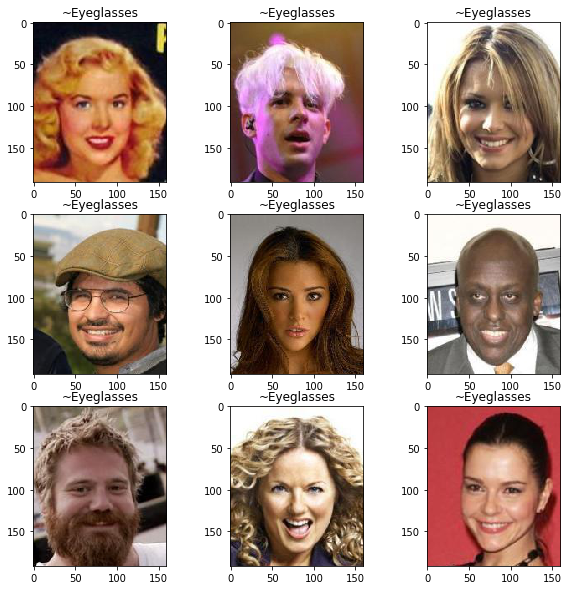

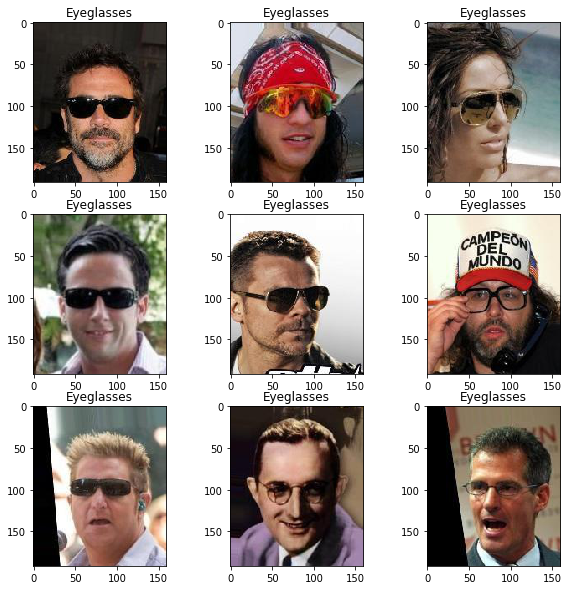

In [15]:
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.title(examined_feature if labels[i]==1 else '~'+examined_feature)
    plt.imshow(np.squeeze(images[i]))
plt.show()
    
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.title(examined_feature if labels[len(labels) - i]==1 else '~'+examined_feature)
    plt.imshow(np.squeeze(images[len(labels) - i]))
plt.show()

## Podział danych na treningowe i testowe

In [16]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

### Standaryzacja danych

In [18]:
X_mean = []
X_std = []
for i in range(3):
    X_mean.append(np.mean(images[:,:,:,i]))
    X_std.append(np.std(images[:,:,:,i]))
    
    X_train[:,:,:,i] = (X_train[:,:,:,i] - X_mean[-1])/X_std[-1]
    X_test[:,:,:,i] = (X_test[:,:,:,i] - X_mean[-1])/X_std[-1]

## Stworzenie modelu

### Zdefiniowanie parametrów określających architekturę modelu

In [19]:
input_shape = images.shape[1:4] #wielkość obrazu wejściowego, wykorzystywana dla budowy grafu SN

### Zdefiniowanie parametrów definujących trening SN

In [20]:
batch_size = 32 #liczba obrazów wykorzystywana do jednego kroku treningu SN
optimizer = 'adam' #funkcja odpowiadająca za redukcję błędu sieci
loss_fn = 'binary_crossentropy' #funkcja służąca do obliczenia o ile różni się wartość oczekiwana od otrzymanej na wyjściu SN
epochs = 30 #maksymalna liczba epok, czyli ile razy sieć będzie widziała dane treningowe
model_path = os.path.join(model_dir,'celeb_cnn_v1.h5')

### Budowa architektury CNN

In [21]:
inputs = Input(shape=input_shape, name='input')

x = Conv2D(64, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=x, name='CNN')
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

### Wprowadzenie funkcji zwrotnych (ang. callback)

Umożliwią nam one dodatkową interakcję z modelem podczas treningu
* zatrzymanie trningu SN jeśli nie ma zauważalnej poprawy funkcji straty dla zbioru walidacyjnego po 3 epokach

In [22]:
early_stop = EarlyStopping(restore_best_weights = True, patience = 3)

* tworzenie punktów kontrolnych w postaci zapisanego modelu po każdej epoce

In [23]:
checkpt = ModelCheckpoint(model_path,save_best_only=True,save_weights_only=True)

### trening SN

In [24]:
history = model.fit(X_train, y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(X_test, y_test),
                  verbose=2,
                  callbacks = [early_stop, checkpt])

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
 - 66s - loss: 8.0026 - acc: 0.5030 - val_loss: 8.2525 - val_acc: 0.4880
Epoch 2/30
 - 57s - loss: 8.0087 - acc: 0.5031 - val_loss: 8.2525 - val_acc: 0.4880
Epoch 3/30
 - 57s - loss: 8.0127 - acc: 0.5029 - val_loss: 8.2525 - val_acc: 0.4880
Epoch 4/30
 - 58s - loss: 8.0107 - acc: 0.5030 - val_loss: 8.2525 - val_acc: 0.4880


In [ ]:
model.load_weights(model_path)